In [8]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
mpl.rcParams["font.size"] = "12"

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, plot_ode, plot_losses, l2
from modules.problems import LotkaVolterra

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
plt.style.use(['grid'])

In [5]:
def get_norms(model):
    norms = {}
    for name, param in model.model.named_parameters():
        weight = param.detach().norm(p=2)
        gradient = param.grad.detach().norm(p=2) if param.grad is not None else None
        norms[name] = [weight, gradient]
    return norms

In [6]:
def get_params(model):
    params = []
    for param in model.parameters():
        params.extend(param.flatten().detach())
    return torch.tensor(params)

In [99]:
def train(
    problem,
    model,
    coef, num_iters, N_D, lr,
    collect_every=500, save_every=500, print_every=1000
):  
    collocation_points = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    preds = model(problem.t.reshape(-1, 1)).detach().cpu().numpy()
    x, y = preds[:,0].flatten(), preds[:,1].flatten()
    min_error = (l2(x, problem.solution[0]) + l2(y, problem.solution[1])) / 2
    
    losses, errors, norms, steps = [], [], [], []

    params = get_params(model)
    for i in range(num_iters + 1):
        
        if i % collect_every == 0:
            preds = model(problem.t.reshape(-1, 1)).detach().cpu().numpy()
            x, y = preds[:,0].flatten(), preds[:,1].flatten()
            error = l2(x, problem.solution[0]) / 2 + l2(y, problem.solution[1]) / 2
            errors.append(error)
        
        optimizer.zero_grad()

        L_I = problem.loss_initial(model)
        L_X, L_Y = problem.loss_physical(model, collocation_points)
        
        L = coef * L_I + (1 - coef) * (L_X + L_Y)
        
        L.backward()
        
        if i % collect_every == 0:
            norms.append(get_norms(model))
            losses.append(np.array([L_I.item(), L_X.item(), L_Y.item(), L.item()]))
            
        optimizer.step()
        
        if i % collect_every == 0 and i > 0:
            curr_params = get_params(model)
            steps.append((curr_params - params).norm(p=2))
            params = curr_params
        
        if i % save_every == 0:
            preds = model(problem.t.reshape(-1, 1)).detach().cpu().numpy()
            x, y = preds[:,0].flatten(), preds[:,1].flatten()
            error = l2(x, problem.solution[0]) / 2 + l2(y, problem.solution[1]) / 2
            
            fig = plt.figure(figsize=(5, 3))

            plt.plot(problem.t, problem.solution[0], label=r'$x(t)$')
            plt.plot(problem.t, problem.solution[1], label=r'$y(t)$')
            plt.plot(problem.t, x, label=r'$\mathcal{X}(t)$')
            plt.plot(problem.t, y, label=r'$\mathcal{Y}(t)$')

            plt.legend()
            plt.title(f'Iteration {i}')
            
            plt.savefig(f'./.temp/Iteration {i}.png', dpi=250)
            plt.close()
        
        if i % print_every == 0:
            print(f'Iteration {i} --- {error}')
        
    return np.array(losses), np.array(errors), norms, np.array(steps)

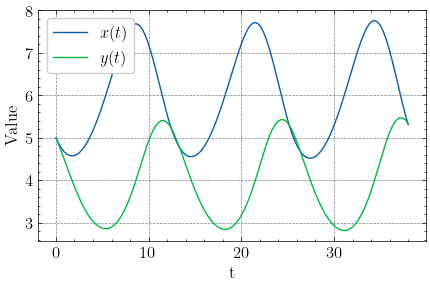

In [8]:
T = 38
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 5, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])

plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

In [139]:
import torch.nn as nn 

L, W = 4, 48
model = FeedForwardNetwork(L, W, input_dim=1, output_dim=2, activation=nn.Tanh()).to(device)
# model.init_weights(init.eye_)

coef = 0.2
num_iters = 15000
N_D = 2048
lr = 1e-2
save_every = 250
collect_every = 500

loss_history, error_history, norm_history, steps = train(
    problem,
    model,
    coef, num_iters, N_D, lr,
    collect_every=collect_every, save_every=save_every, print_every=1000
)

Iteration 0 --- 55.358137920637205
Iteration 1000 --- 10.80741611719257
Iteration 2000 --- 10.468055568567099
Iteration 3000 --- 10.265862841111257
Iteration 4000 --- 9.717364705264092
Iteration 5000 --- 9.45967997263951
Iteration 6000 --- 8.677157282071411
Iteration 7000 --- 7.842602151549629
Iteration 8000 --- 8.157633471276608
Iteration 9000 --- 6.637563588468085
Iteration 10000 --- 9.117941486001595
Iteration 11000 --- 8.687294029199194
Iteration 12000 --- 8.294018166021905
Iteration 13000 --- 7.802337694724615
Iteration 14000 --- 7.307328320636891
Iteration 15000 --- 6.839288277054465


In [140]:
import imageio
imgs = []
for filename in [f'./.temp/Iteration {i}.png' for i in range(0, num_iters+1, save_every)]:
    imgs.append(imageio.imread(filename))
    imageio.mimsave('../images/animations/lv4_double_learning.gif', imgs, duration=5, fps=60, loop=0)

C:\Temp\ipykernel_12336\987264485.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(filename))


In [135]:
def get_report_data(loss_history, norm_history):

    layers = norm_history[0].keys()

    layers_history = {key: list() for key in layers}
    gradients_history = {key: list() for key in layers}
    for layer in layers:
        for norms in norm_history:
            layer_norm = norms[layer][0].item()
            grad_norm = norms[layer][1].item() if norms[layer][1] is not None else None
            layers_history[layer].append(layer_norm)
            gradients_history[layer].append(grad_norm)
            
    losses=[
        (loss_history[:,0], r'$\mathcal{L_I}$'),
        (loss_history[:,1], r'$\mathcal{L_X}$'),
        (loss_history[:,2], r'$\mathcal{L_Y}$'),
        (loss_history[:,3], r'$\mathcal{L_T}$')
    ]
    
    return losses, gradients_history, layers_history

def plot_report(
    t: np.ndarray, 
    losses: np.ndarray, 
    errors: np.ndarray, 
    steps: np.ndarray, 
    gradients_history: dict, 
    layers_history: dict,
    interesting_iteration: int,
    size: tuple = (7.5, 5),
    mean_grads = True
    ):

    fig, ax = plt.subplots(2, 2, figsize=size, width_ratios=[4, 3], height_ratios=[1, 1])

    if mean_grads:
        gradients = []
        for layer in gradients_history:
            gradients.append(gradients_history[layer])
        ax[0, 0].plot(t, np.array(gradients).mean(axis=0), label='Gradients Mean')
    
    else:    
        for layer in gradients_history:
            if 'bias' not in layer:
                ax[0, 0].plot(t, gradients_history[layer], label=layer)
    
    for layer in layers_history:
        if 'bias' not in layer:
            ax[0, 1].plot(t, layers_history[layer], label=layer)

    ax[0, 0].title.set_text('Gradient Norms')
    ax[0, 1].title.set_text('Layer Norms')
    
    ax[0, 0].set(xticklabels=[])
    ax[0, 1].set(xticklabels=[])

    ax[0, 0].set_yscale('log')
    ax[0, 1].legend(loc='upper left', bbox_to_anchor=(-1.58, 1.55),
            ncol=3, fancybox=True, shadow=True)

    for loss, name in losses:
        ax[1, 0].plot(t, loss, label=name)
    ax[1, 1].plot(t, errors, label='L2')
    ax[1, 1].plot(t, steps, label='SN')

    ax[1, 0].set_yscale('log')
    ax[1, 1].set_yscale('log')

    ax[1, 0].legend(ncol=2)
    ax[1, 1].legend(ncol=2)
    
    ax[1, 0].title.set_text('Loss Dynamics')
    ax[1, 1].title.set_text('L2 \& Step Dynamics')
    
    for i, j in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        for line in interesting_iteration:
            ax[i, j].axvline(x=line, ls=':', color='black')

    plt.savefig(f'../images/report.png', dpi=250)
    plt.show()

In [73]:
plt.style.use('grid')

In [129]:
len(norm_history), len(loss_history)

(151, 151)

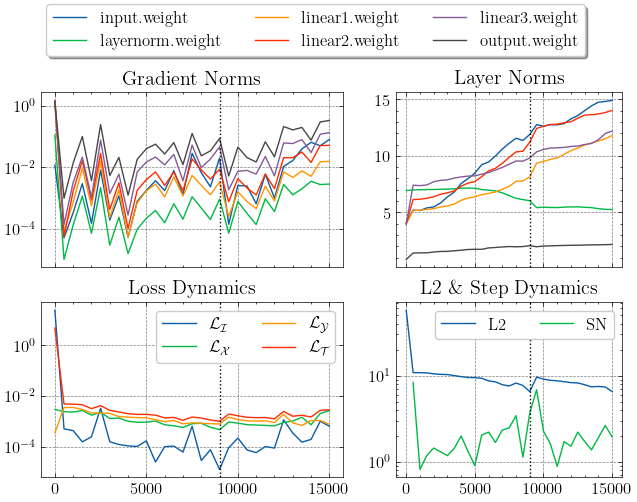

In [142]:
losses, gradients_history, layers_history = get_report_data(loss_history, norm_history)

t = np.arange(0, num_iters + 1, collect_every)
plot_report(t, losses, error_history, [None] + list(steps), gradients_history, layers_history, interesting_iteration = [9000], mean_grads=False)

## Interesting problem statements
---

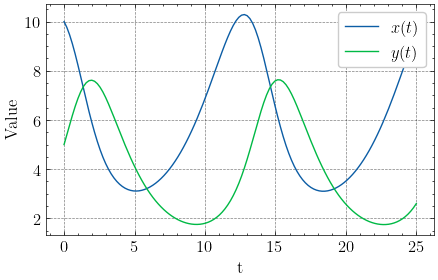

In [5]:
# Default
T = 25
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 10, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

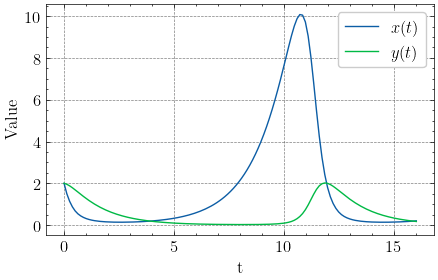

In [101]:
# Pretty sharp solution.
T = 16
alpha, beta, delta, gamma = 0.7, 1.5, 0.3, 0.7
x_0, y_0 = 2, 2
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

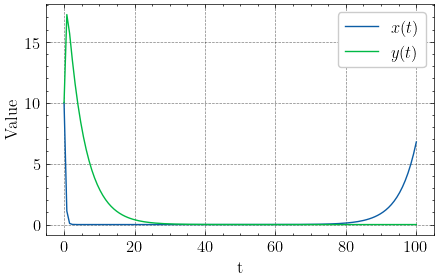

In [90]:
# This solution is exhibit pretty usual behavior for L-V system.
T = 100
alpha, beta, delta, gamma = 0.2, 0.2, 0.2, 0.2
x_0, y_0 = 10, 10
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

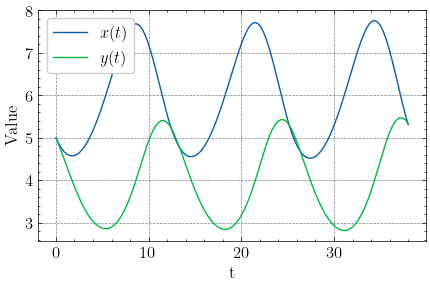

In [62]:
# Default parameters with different initialization and larger time T.
T = 38
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 5, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

In [2]:
def get_problem(N):
    match N:
        case 1:
            T = 25
            alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
            x_0, y_0 = 10, 5
            
        case 2:
            T = 16
            alpha, beta, delta, gamma = 0.7, 1.5, 0.3, 0.7
            x_0, y_0 = 2, 2
            
        case 3:
            T = 100
            alpha, beta, delta, gamma = 0.2, 0.2, 0.2, 0.2
            x_0, y_0 = 10, 10
            
        case 4:
            T = 38
            alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
            x_0, y_0 = 5, 5
    
    problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
    
    return problem

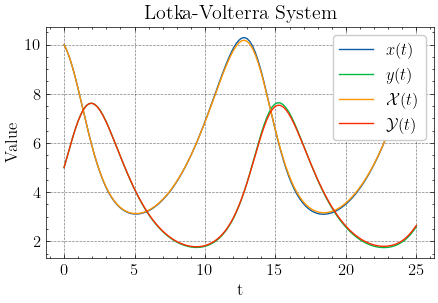

In [8]:
problem = get_problem(1)
test_model = torch.load('./studies/lv_1_best_model.pt', map_location='cpu')

preds = test_model(problem.t.reshape(-1, 1)).detach().numpy()
x = preds[:,0].flatten()
y = preds[:,1].flatten()

plot_ode(
    problem.t.numpy(), 
    solutions=[(problem.solution[0], r'$x(t)$', None), (problem.solution[1], r'$y(t)$', None)],
    predicted=[(x, r'$\mathcal{X}(t)$', None), (y, r'$\mathcal{Y}(t)$', None)],
    title='Lotka-Volterra System', size=(5, 3)
)

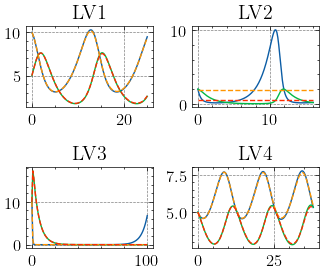

In [60]:
problems = [get_problem(i) for i in range(1, 5)]

size = (3.5, 3)
fig, axs = plt.subplots(2, 2, figsize=size)
for (i, j), (ind, problem) in zip([(0, 0), (0, 1), (1, 0), (1, 1)], enumerate(problems)):
    axs[i, j].plot(problem.t, problem.solution[0])
    axs[i, j].plot(problem.t, problem.solution[1])
    
    test_model = torch.load(f'./studies/lv_{ind + 1}_best_model.pt', map_location='cpu')

    preds = test_model(problem.t.reshape(-1, 1)).detach().numpy()
    x = preds[:,0].flatten()
    y = preds[:,1].flatten()
    
    axs[i, j].plot(problem.t, x, linestyle='dashed')
    axs[i, j].plot(problem.t, y, linestyle='dashed')
    
    axs[i, j].title.set_text(f'LV{ind+1}')
    
plt.tight_layout()

plt.savefig('../images/lv_solutions_grid.png', dpi=250)
plt.show()

## Hyperparameters tuning
---

In [31]:
import optuna

best_model = None
model = None

study_name = None

def objective(trial):
    
    global model
    
    L = trial.suggest_int('L', 2, 6, step=2)
    W = trial.suggest_int('W', 32, 128, step=32)
    
    # activation = trial.suggest_categorical('activation', ['tanh', 'tanh'])
    model = FeedForwardNetwork(L, W, input_dim=1, output_dim=2).to(device)
    # init_rule = trial.suggest_categorical('initialization', ['default', 'zeros', 'eye', 'normal'])
    
    N_D = trial.suggest_int('N_D', 512, 1024 * 4, step=512)
    lr = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
    
    coef = trial.suggest_float('coef', 0.05, 0.95)
    
    # if init_rule == 'zeros':
    #     model.init_weights(init.zeros_)
    # elif init_rule == 'eye':
    #     model.init_weights(init.eye_)
    # else: 
    #     model.init_weights(init.normal_)
        
    torch.save(model, f'./studies/saved models/{study_name}_{trial.number}.pt')
    
    # sampling = trial.suggest_categorical('sampling', ['random', 'grid'])
    
    sampling = 'grid'
    if sampling == 'random':
        collocation_points = torch.tensor(np.random.uniform(0, problem.T, N_D), dtype=torch. float32, requires_grad=True).reshape(-1, 1).to(device)
    else:
        collocation_points = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for i in range(15000):

        optimizer.zero_grad()

        L_I = problem.loss_initial(model)
        L_X, L_Y = problem.loss_physical(model, collocation_points)

        L = coef * L_I + (1 - coef) * (L_X + L_Y)

        L.backward()
        optimizer.step()
        
        if (i + 1) % 1000 == 0:
            preds = model(problem.t.reshape(-1, 1)).detach().cpu().numpy()
            x, y = preds[:,0].flatten(), preds[:,1].flatten()
            error = (l2(x, problem.solution[0]) + l2(y, problem.solution[1])) / 2
            
            trial.report(error, i + 1)
            
            if trial.should_prune():
                raise optuna.TrialPruned()
            
    return error

def callback(study, trial):
    global best_model
    
    if study.best_trial == trial:
        best_model = model

In [32]:
for problem_number in range(1, 2):
    problem = get_problem(problem_number)

    study = optuna.create_study(
        study_name=f'lv_{problem_number}',
        direction='minimize', 
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(max_resource=15000)
        )
    
    study_name = study.study_name

    study.optimize(objective, n_trials=50, callbacks=[callback])
    study.trials_dataframe().to_csv(f'./studies/{study_name}.csv', sep=',')
        
    torch.save(best_model, f'./studies/{study_name}_best_model.pt')

[I 2024-04-03 16:25:01,351] A new study created in memory with name: lv_1
[W 2024-04-03 16:25:06,812] Trial 0 failed with parameters: {'L': 6, 'W': 128, 'initialization': 'default', 'N_D': 6144, 'lr': 0.0015085692865496035, 'coef': 0.5170240584671877, 'sampling': 'random'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Temp\ipykernel_16376\3530040992.py", line 49, in objective
    L.backward()
  File "c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\__init__.py", line 251, in backward
    Variable._execution_engine.run_backward(  # Calls into th

KeyboardInterrupt: 

In [ ]:
test_model = torch.load(f'./studies/lv_1_best_model.pt', map_location='cpu')

preds = test_model(problem.t.reshape(-1, 1)).detach().numpy()
x, y = preds[:,0].flatten(), preds[:,1].flatten()

plot_ode(
    problem.t.numpy(), 
    solutions=[(problem.solution[0], r'$x(t)$', None), (problem.solution[1], r'$y(t)$', None)],
    predicted=[(x, r'$\mathcal{X}(t)$', None), (y, r'$\mathcal{Y}(t)$', None)],
    title='Lotka-Volterra System', size=(5, 3)
)

## Hyperparameter analysis
---

In [1]:
import pandas as pd
from datetime import datetime
from modules.utils import get_corr, plot_rmse_corr

In [2]:
new_names = ['l2', 'duration', 'L', 'N_D', 'W', 'coef', 'init', 'lr', 'state']

def convert(duration):
    pt = datetime.strptime(duration[duration.find('days')+5:],'%H:%M:%S.%f')
    return pt.second + pt.minute*60 + pt.hour*3600

rungs = [f'system_attrs_completed_rung_{i}' for i in range(9)]
lv1 = pd.read_csv('./studies/lv_1.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'] + rungs, axis=1)
lv2 = pd.read_csv('./studies/lv_2.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'] + rungs, axis=1)
lv3 = pd.read_csv('./studies/lv_3.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'] + rungs, axis=1)
lv4 = pd.read_csv('./studies/lv_4.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'], axis=1)

for df in [lv1, lv2, lv3, lv4]:
    df.columns = new_names
    df['duration'] = df['duration'].apply(convert)

In [30]:
lv1.sort_values('l2').head(10)

,l2,duration,L,N_D,W,coef,init,lr,state
4,0.511318,273,6,1024,128,0.279750,default,0.000229,COMPLETE
14,0.530998,224,2,3584,128,0.396718,kaiming,0.010297,COMPLETE
56,0.824616,226,4,3584,128,0.249691,kaiming,0.003025,COMPLETE
57,1.632504,40,6,3584,128,0.239888,kaiming,0.003126,PRUNED
11,3.327731,216,2,3072,128,0.922432,kaiming,0.006662,COMPLETE
62,3.400965,31,2,5632,128,0.112353,xavier,0.006200,PRUNED
55,5.218073,179,2,5632,128,0.240295,eye,0.003224,COMPLETE
8,7.042951,227,2,4608,96,0.801515,eye,0.013688,COMPLETE
31,7.520541,227,2,4608,96,0.845910,eye,0.023317,COMPLETE
32,9.322234,228,2,5120,96,0.820899,eye,0.012140,COMPLETE


In [31]:
lv2.sort_values('l2').head(10)

,l2,duration,L,N_D,W,coef,init,lr,state
84,18.650260,6,2,6656,64,0.745653,zeros,0.063230,PRUNED
97,18.665581,7,6,5632,128,0.641124,normal,0.044144,PRUNED
49,18.711832,10,8,3072,32,0.602530,normal,0.113393,PRUNED
98,18.813404,7,4,4608,96,0.545940,xavier,0.630621,PRUNED
11,18.817162,200,4,5120,64,0.507020,zeros,0.688218,COMPLETE
95,18.818314,7,6,6144,128,0.392921,zeros,0.151037,PRUNED
83,18.818867,7,2,5120,64,0.512172,zeros,0.132719,PRUNED
69,18.826884,10,8,4608,32,0.587293,eye,0.140123,PRUNED
53,18.826885,7,6,4096,64,0.587421,default,0.280369,PRUNED
96,18.827005,7,2,4096,32,0.571950,zeros,0.807803,PRUNED


In [32]:
lv3.sort_values('l2').head(10)

,l2,duration,L,N_D,W,coef,init,lr,state
83,6.523595,225,4,4608,64,0.114470,eye,0.002001,COMPLETE
15,6.527553,244,4,4096,64,0.115525,xavier,0.000101,COMPLETE
10,6.531680,197,2,5120,96,0.903102,xavier,0.000198,COMPLETE
16,6.603423,235,6,4096,64,0.090142,zeros,0.000158,COMPLETE
58,6.629621,9,8,6144,96,0.172723,xavier,0.002550,PRUNED
98,6.631472,6,2,3072,96,0.074332,xavier,0.001237,PRUNED
37,6.818434,9,8,6656,64,0.566386,xavier,0.007890,PRUNED
32,8.014515,8,4,1536,128,0.819423,xavier,0.003166,PRUNED
65,8.230174,9,8,3072,64,0.161386,xavier,0.001470,PRUNED
18,8.723427,7,4,2048,64,0.231725,xavier,0.001153,PRUNED


In [33]:
lv4.sort_values('l2').head(10)

,l2,duration,L,N_D,W,coef,init,lr,state
37,0.565381,303,8,3072,96,0.447807,xavier,0.001279,COMPLETE
85,0.772445,300,8,1536,64,0.485949,xavier,0.002811,COMPLETE
74,0.831503,300,8,1536,64,0.557085,xavier,0.003080,COMPLETE
41,0.842162,303,8,2560,96,0.359039,xavier,0.001569,COMPLETE
45,0.874148,299,8,2560,64,0.450276,default,0.001390,COMPLETE
46,1.082783,312,8,5120,96,0.436710,default,0.001613,COMPLETE
91,1.108441,300,8,1536,64,0.407631,xavier,0.002751,COMPLETE
36,1.259888,305,8,3072,64,0.456511,xavier,0.003465,COMPLETE
6,1.488564,236,4,512,64,0.652566,eye,0.002812,COMPLETE
35,4.489960,308,8,2048,64,0.489588,xavier,0.003955,COMPLETE


In [6]:
import matplotlib.pyplot as plt
import numpy as np

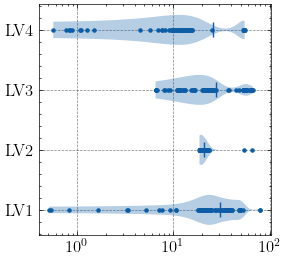

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

dfs = [lv1, lv2, lv3, lv4]
data = [df['l2'].to_numpy() for df in dfs]

ax.violinplot(
    [df['l2'].to_numpy() for df in dfs],
    showextrema=False, showmeans=True, vert=False
)
ax.set_yticks(ticks=[1, 2, 3, 4], labels=['LV1', 'LV2', 'LV3', 'LV4'])
ax.set_xscale('log')
ax.scatter(
    x=data,
    y=[np.ones(100)*i for i in range(1, 5)], 
    s=5
)

plt.savefig('../images/lv_violins.png', dpi=250)

plt.show()

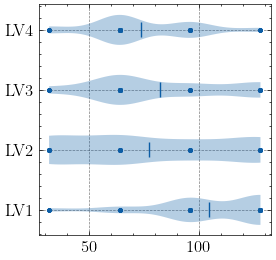

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

dfs = [lv1, lv2, lv3, lv4]
data = [df['W'].to_numpy() for df in dfs]

ax.violinplot(
    [df['W'].to_numpy() for df in dfs],
    showextrema=False, showmeans=True, vert=False
)
ax.set_yticks(ticks=[1, 2, 3, 4], labels=['LV1', 'LV2', 'LV3', 'LV4'])
# ax.set_xscale('log')
ax.scatter(
    x=data,
    y=[np.ones(100)*i for i in range(1, 5)], 
    s=5
)

# plt.savefig('../images/lv_violins.png', dpi=250)

plt.show()

Instances of group...
eye - 46
normal - 9
zeros - 45


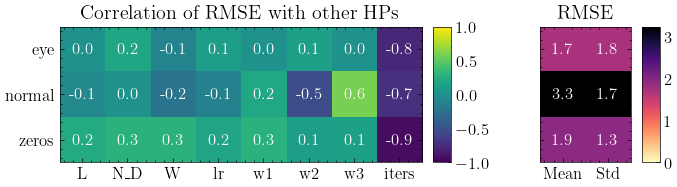

In [13]:
correlation, rmse_data, xlabels, ylabels = get_corr(lv1)
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels)

Instances of group...
eye - 14
normal - 74
zeros - 12


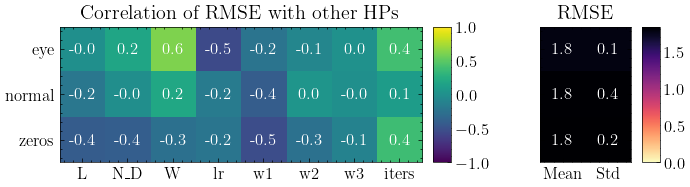

In [14]:
correlation, rmse_data, xlabels, ylabels = get_corr(lv2)
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels)

Instances of group...
eye - 74
normal - 10
zeros - 16


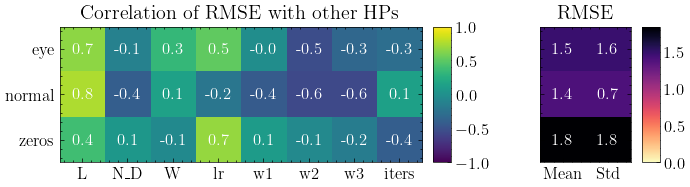

In [15]:
correlation, rmse_data, xlabels, ylabels = get_corr(lv3)
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels)

In [ ]:
correlation, rmse_data, xlabels, ylabels = get_corr(lv4)
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels)